In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic2"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import load_excel, load_odin_as_ml_dataset, plot_confusion_matrix, make_ml_dataset, run_binary_regression, transport_modes

Changed to c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation


In [2]:
# Here just in case
year = 2022
odin_excel_path = os.path.join(os.getcwd(), "data", "OdiN 2019-2023", f"OdiN {year}", f"ODiN{year}_Databestand.csv")
df = load_excel(odin_excel_path)
df = df[df["Verpl"] == 1]

Loaded file from CSV


In [3]:
print(transport_modes)

{1: 'Car - driver', 2: 'Car - passenger', 3: 'Train', 4: 'Bus/tram/metro', 5: 'Bicycle', 6: 'On foot', 7: 'Other'}


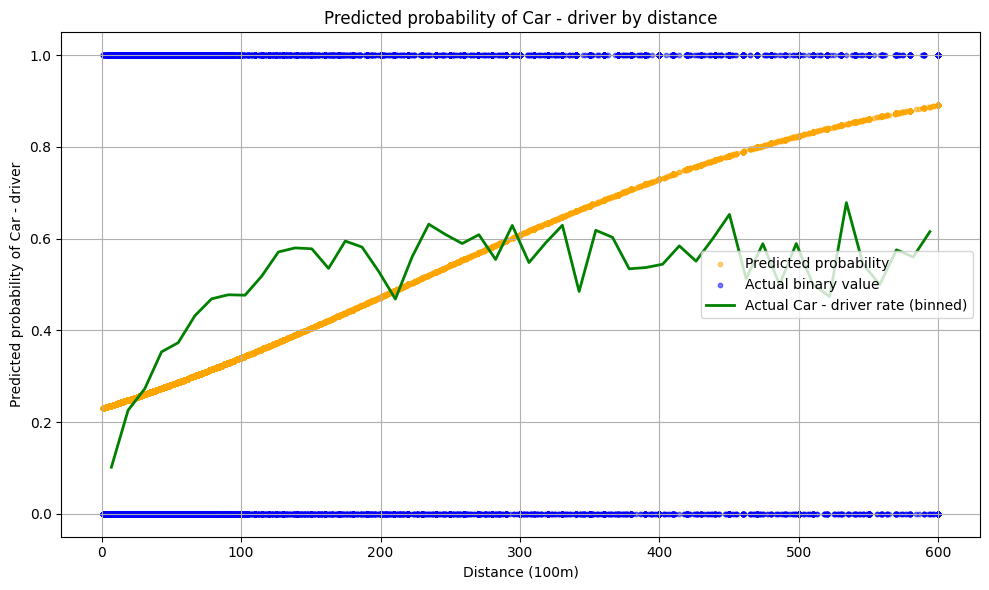

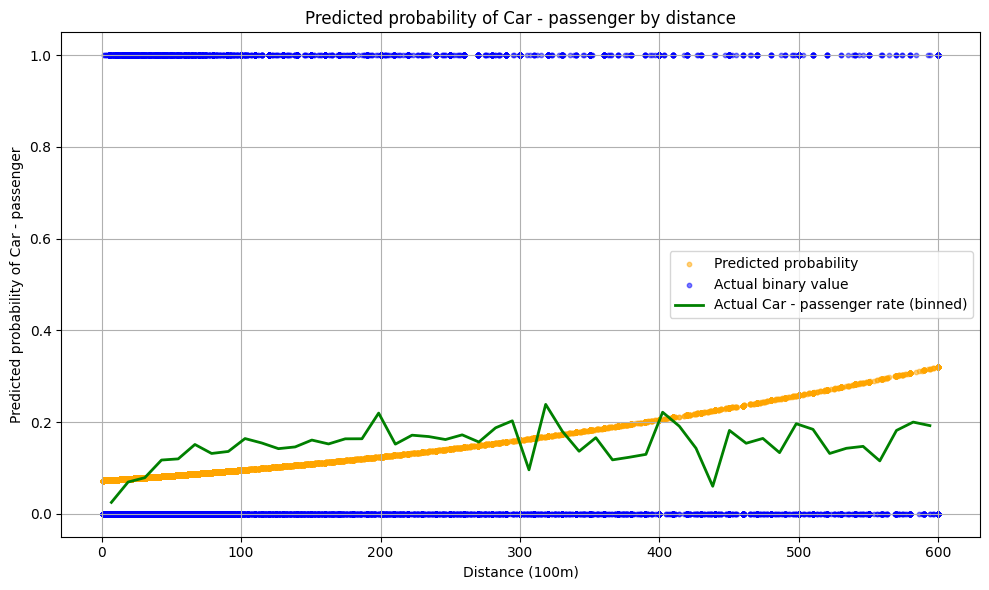

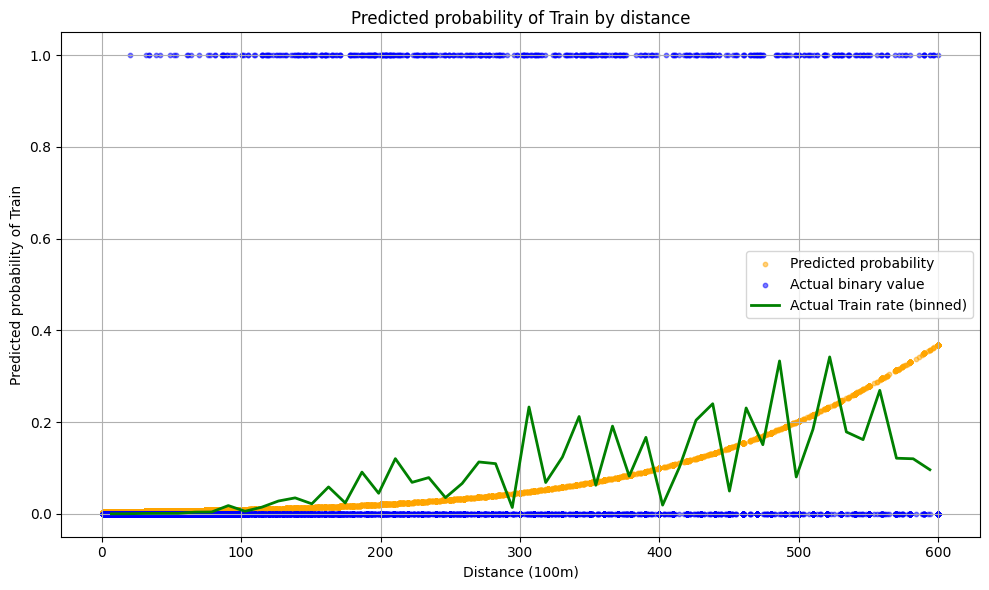

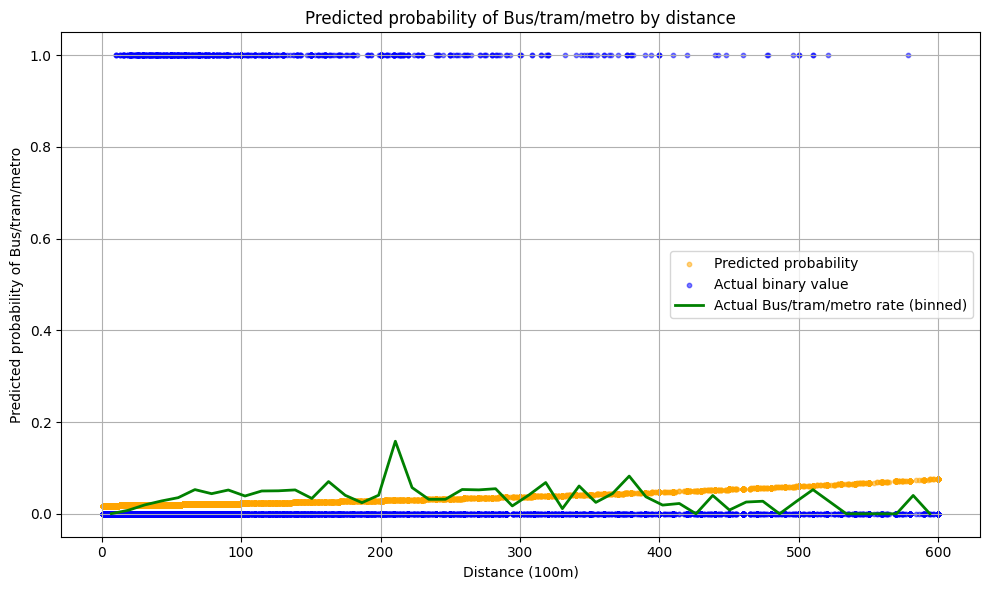

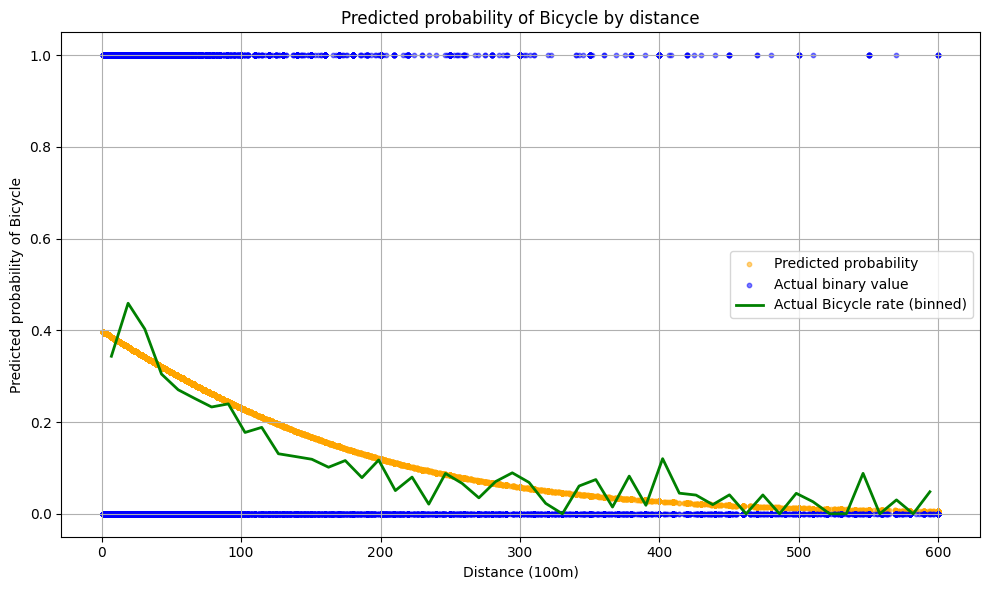

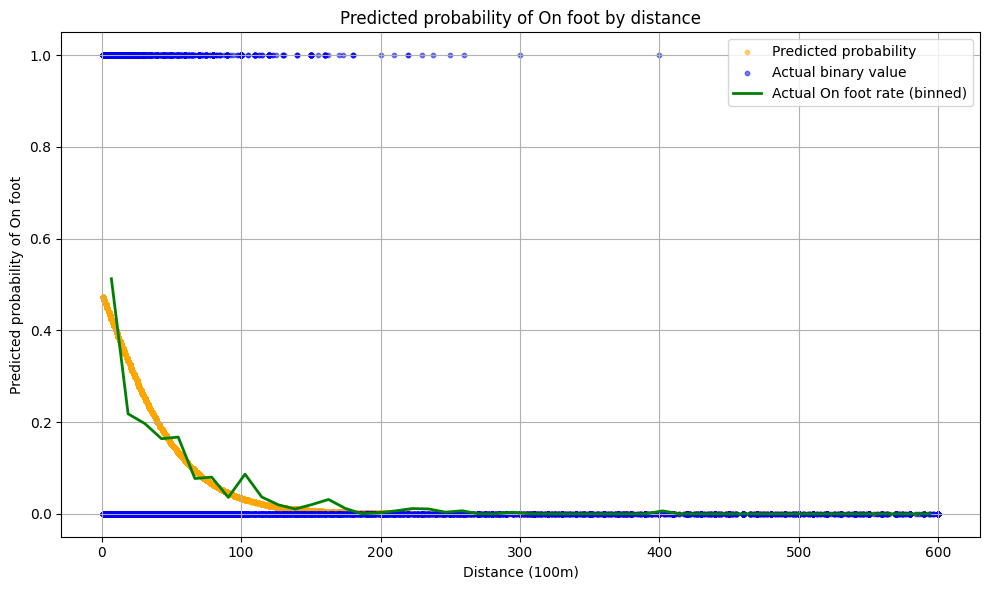

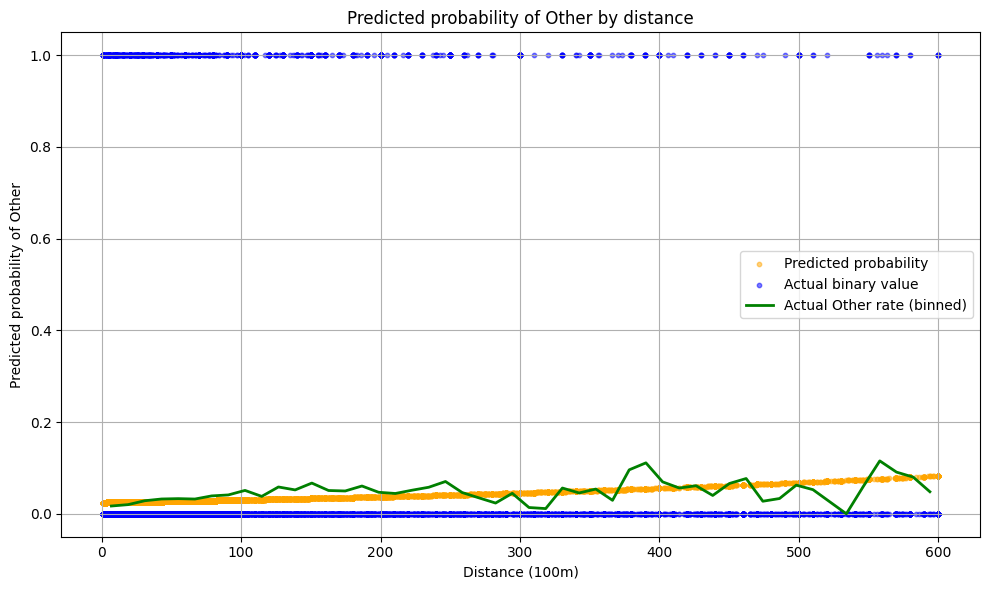

In [5]:
max_dist=600 # max distance in 100s of meters

for transport_mode in transport_modes.keys():
    run_binary_regression(
        df,
        test_size=0.2,
        transport_mode=transport_mode,
        max_dist=max_dist,
        savename=f"graphics/classification_results/binary_regression_{transport_modes[transport_mode]}_{max_dist}",
    )

Now a classifier that takes the origin and distance into account 